# <center> <strong> Проект: Задача классификации </strong>

## Описание проекта:

Мне предоставили данные о последней маркетинговой кампании, которую проводил банк: задачей было привлечь клиентов для открытия депозита. Моя задача  проанализировать эти данные, выявить закономерность и найти решающие факторы, повлиявшие на то, что клиент вложил деньги именно в этот банк.

<strong>Бизнес-задача:</strong> определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.

<strong>Техническая задача:</strong> построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

In [2]:
#Ипорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
%matplotlib inline
plt.style.use('seaborn-v0_8')

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

Давайте для начала посмотрим на то, какими признаками представленны наши данные:

<strong>Данные о клиентах банка:</strong>

* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды);
* balance (баланс).

<strong>Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:</strong>

* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).

<strong>Прочие признаки:</strong>

* campaign (количество контактов с этим клиентом в течение текущей кампании);
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).

И, разумеется, наша целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

In [3]:
#Считываем наши данные
df = pd.read_csv('./data/bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


Посмотрим на основную информацию о наших данных.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


Можем сразу заметить, что в данных у признака balance есть пропуски, также он представлен не тем типом данных, давайте это исправим.

In [5]:
# преобразуем признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def balance_preprocessing(balance):
    balance = str(balance)
    balance = balance.replace(',', '.')
    balance = balance.replace('$', '')
    balance = balance.replace(' ', '')
    balance = float(balance)
    return balance

df_copy = df.copy()
df_copy['balance'] = df_copy['balance'].apply(balance_preprocessing)
print('Итоговый тип переменной: {}'.format(df_copy['balance'].dtype))

Итоговый тип переменной: float64


После приведения к нужному типу избавимся от пропусков, так как их немного, просто заполняем их модальным значением.

In [6]:
# обработаем пропуски в признаки balance , заменив их на медианные значения по данному признаку
df_copy['balance'] = df_copy['balance'].fillna(df_copy['balance'].median())
print(f'Количество пропусков после заполнения: {df_copy.balance.isnull().sum()}')

Количество пропусков после заполнения: 0


Компания заранее сообщила, что в признаках job и education присутствуют скрытые пропуски, они представлены строкой unknown. Посмотрим какой процент они занимают.

In [7]:
display(df_copy['job'].value_counts(normalize=True) * 100)
display(df_copy['education'].value_counts(normalize=True) * 100)

job
management       22.988712
blue-collar      17.416234
technician       16.332199
admin.           11.951263
services          8.269127
retired           6.970077
self-employed     3.628382
student           3.225228
unemployed        3.198352
entrepreneur      2.938541
housemaid         2.454757
unknown           0.627128
Name: proportion, dtype: float64

education
secondary    49.059308
tertiary     33.049633
primary      13.438452
unknown       4.452607
Name: proportion, dtype: float64

Видим, что они также занимают небольшую часть данных, поэтому просто заполняем их модальными значениями.

In [8]:
# обрабатываем пропуски в категориальных признаках: job и education, заменив их на модальные значения
for feature in ['job', 'education']:
    df_copy[feature] = df_copy[feature].apply(lambda x: df_copy[feature].mode()[0] if x == 'unknown' else x)

Теперь займемся обработкой выбросов в признаке balance, я воспользуюсь методом Тьюки для их определения. Давайте визуализируем коробчатую диаграму и гистограмму.

Text(0.5, 1.0, 'Коробчатая диаграма признака balance')

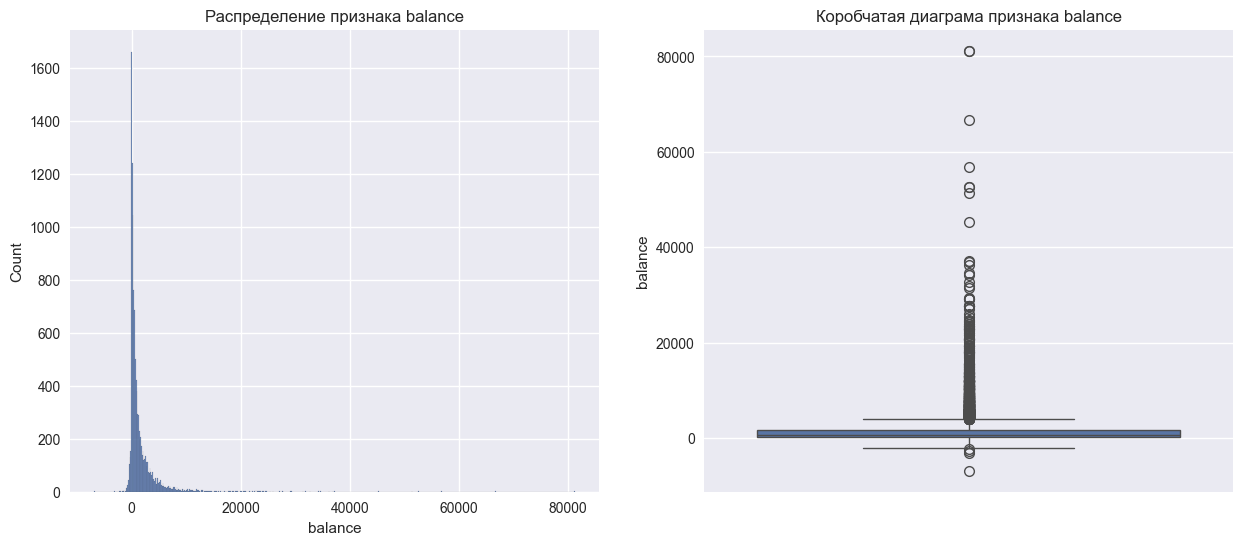

In [9]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

hist = sns.histplot(data=df_copy, x='balance', ax=axes[0])
hist.set_title('Распределение признака balance')

boxplot = sns.boxplot(data=df_copy['balance'], ax=axes[1])
boxplot.set_title('Коробчатая диаграма признака balance')

Из графика сразу заметно наличие выбросов, а также то, что признак имеет распределение схожее с логнормальным, давайте очистим наши данные от выбросов.

In [10]:
# удалим все выбросы для признака balance
x = df_copy['balance']
quantile_1, quantile_3 = x.quantile(0.25), x.quantile(0.75)
iqr = quantile_3 - quantile_1
# рассчитываем нижнюю и верхнию границы
lower_bound = quantile_1 - 1.5 * iqr
upper_bound = quantile_3 + 1.5 * iqr
print(f'Границы {(lower_bound, upper_bound)}')

#очищаем данные от выбросов
mask = (df_copy['balance'] >= lower_bound) & (df_copy['balance'] <= upper_bound)
df_copy = df_copy[mask]
print(f'Итоговые размеры данных: {df_copy.shape}')

df = df_copy

Границы (-2241.0, 4063.0)
Итоговые размеры данных: (10105, 17)


## Часть 2:  Разведывательный анализ

Первым делом изучим наши данные на сбалансированность классов.

In [11]:
# изучим соотношение классов в ваших данных на предмет несбалансированности
display(df['deposit'].value_counts(normalize=True) * 100)

deposit
no     53.676398
yes    46.323602
Name: proportion, dtype: float64

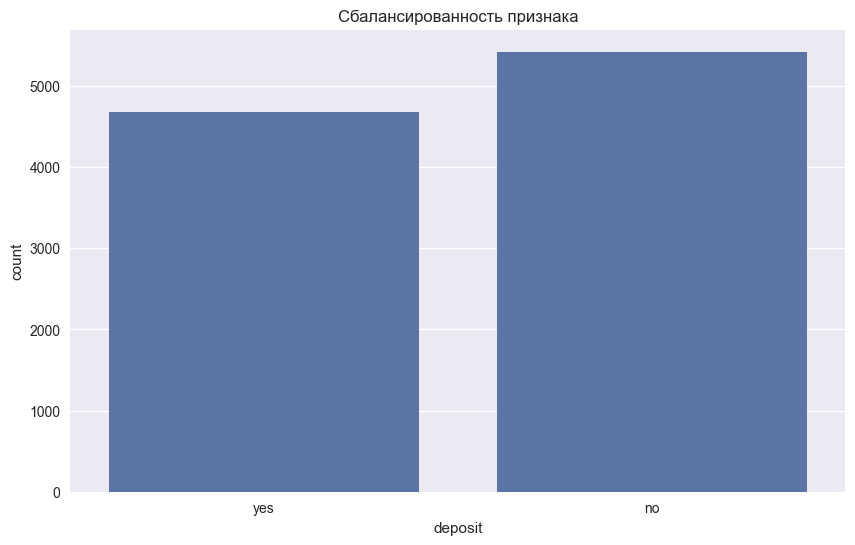

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))

bar = sns.countplot(data=df, x='deposit', ax=ax)
bar.set_title('Сбалансированность признака');

Посмотрим на описательные статистики для числовых переменных.

In [13]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


Для категориальных.

In [14]:
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


Визуализируем, как зависит целевой признак, от категориальных.

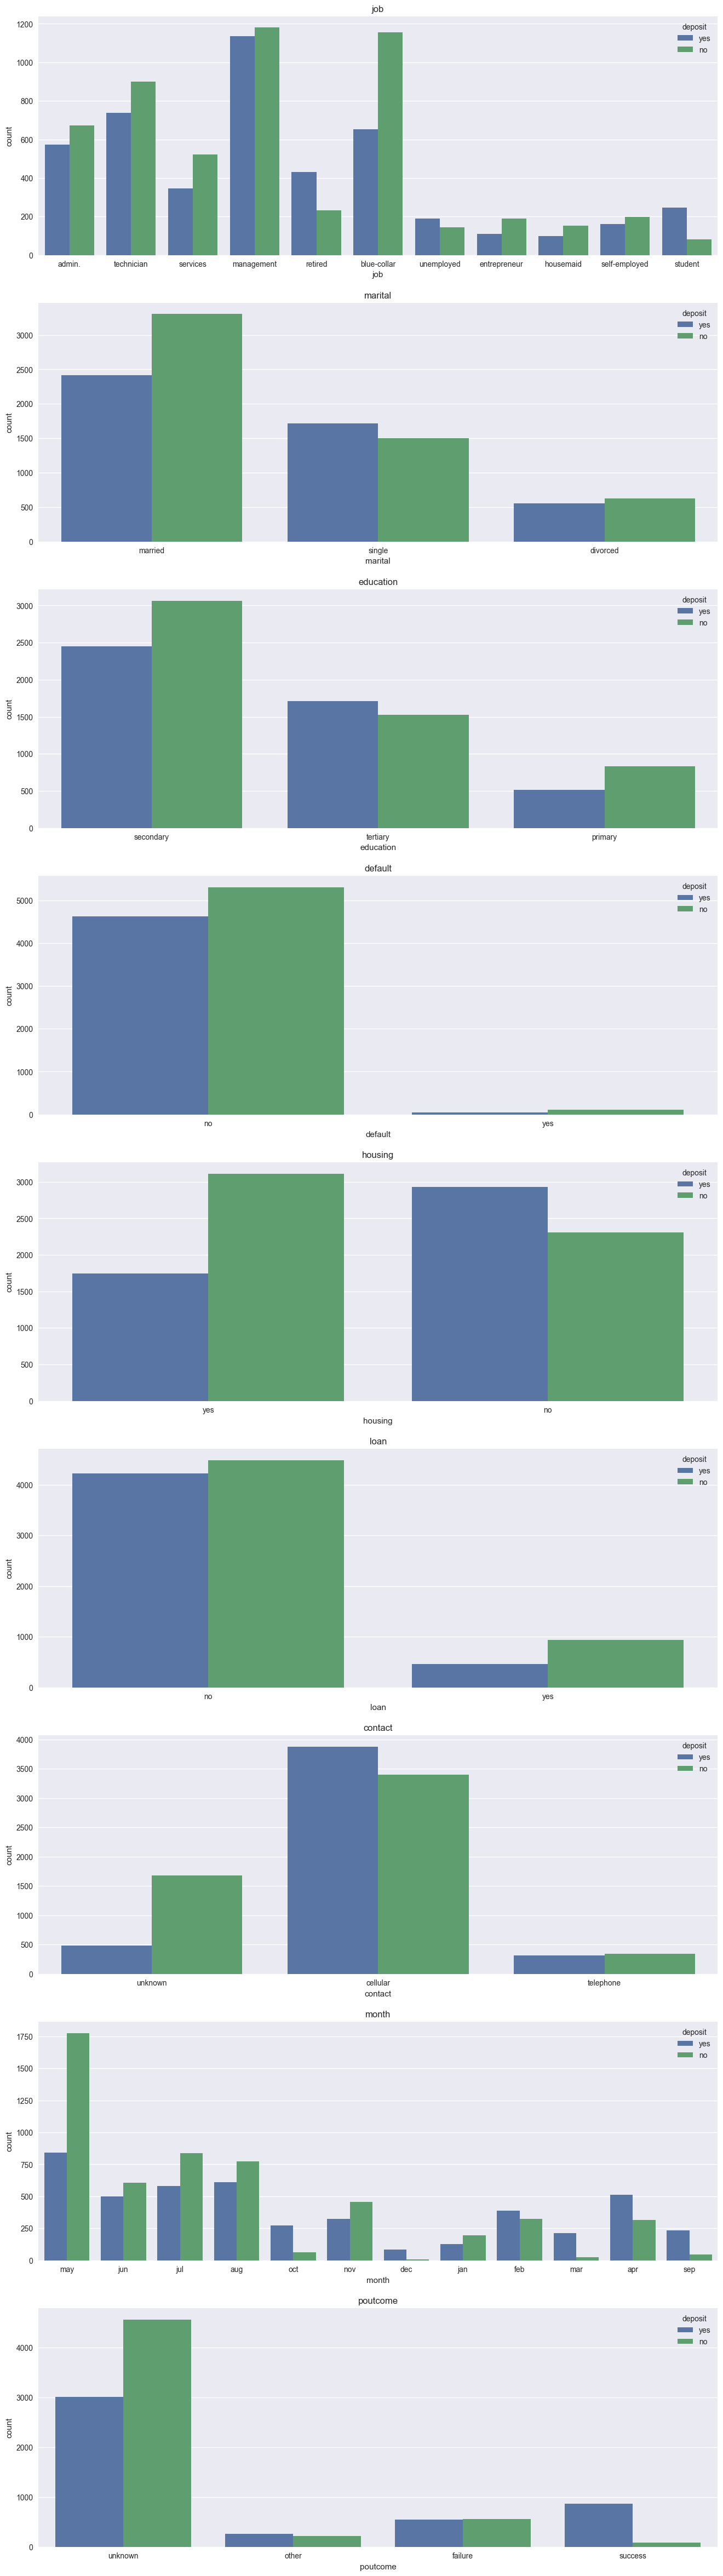

In [15]:
cats = [feature for feature in df.columns if (df[feature].dtype == 'object') and (feature != 'deposit')]

fig, axes = plt.subplots(9, 1, figsize = (16, 60))
for idx, feature in enumerate(cats):
    countplot = sns.countplot(data=df, x=feature, hue='deposit', ax=axes[idx])
    countplot.set_title(feature)

Узнаем, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

In [16]:
df.groupby(['poutcome'], as_index=False)['deposit'].value_counts(normalize=True)

,poutcome,deposit,proportion
0,failure,no,0.506763
1,failure,yes,0.493237
2,other,yes,0.550936
3,other,no,0.449064
4,success,yes,0.911111
5,success,no,0.088889
6,unknown,no,0.602642
7,unknown,yes,0.397358


Посмотрим в каком месяце чаще всего отказывались от предложения открыть депозит.

In [17]:
temp = df.groupby('month', as_index=False)['deposit'].value_counts(normalize=True)
temp[temp['deposit'] == 'no'].sort_values('proportion', ascending=False)['month'].iloc[0]

'may'

Создадим признак, который будет соответствовать возрастной категории клиента, а также посмотрим на зависимость целевой переменной от этого признака.

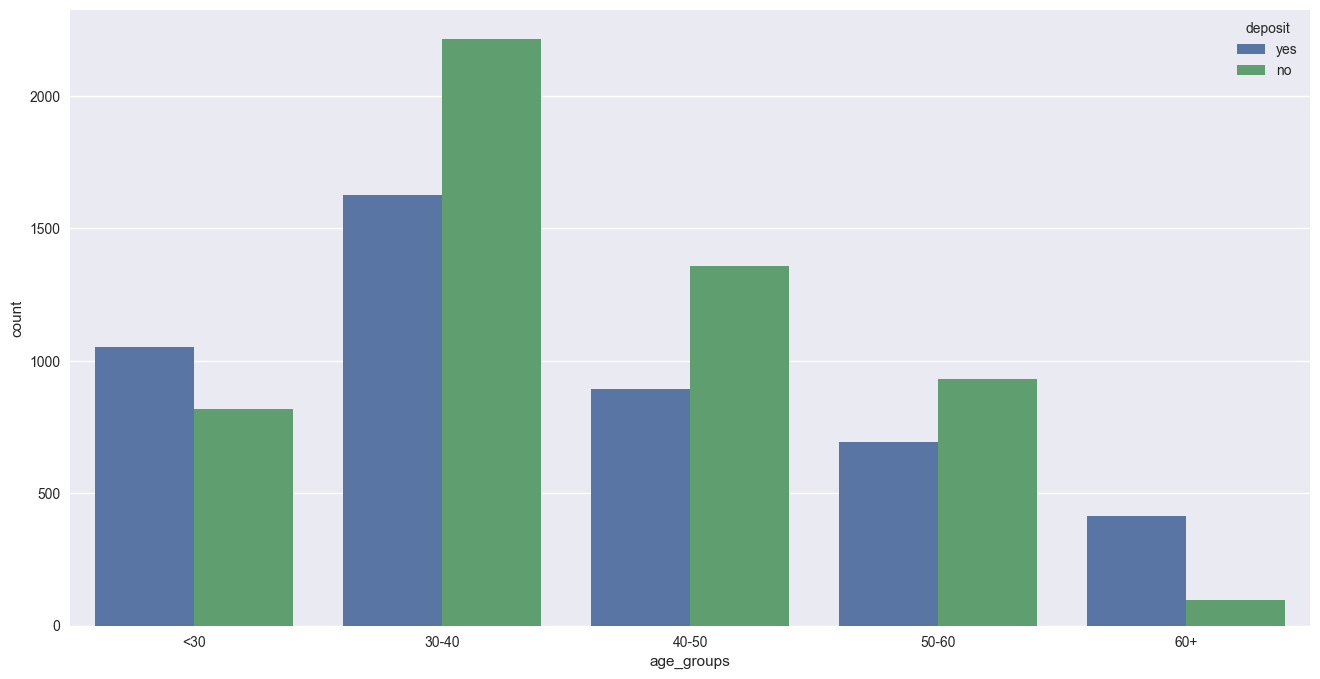

In [18]:
df['age_groups'] = pd.cut(df['age'], [0, 30, 40, 50, 60, 9999], labels=['<30', '30-40', '40-50', '50-60', '60+'])

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
countplot = sns.countplot(data=df, x='age_groups', hue='deposit', ax=ax)

Посмотрим на то, сколько людей соглашаются на открытие депозита в зависимости от уровня образования и семейного положения.

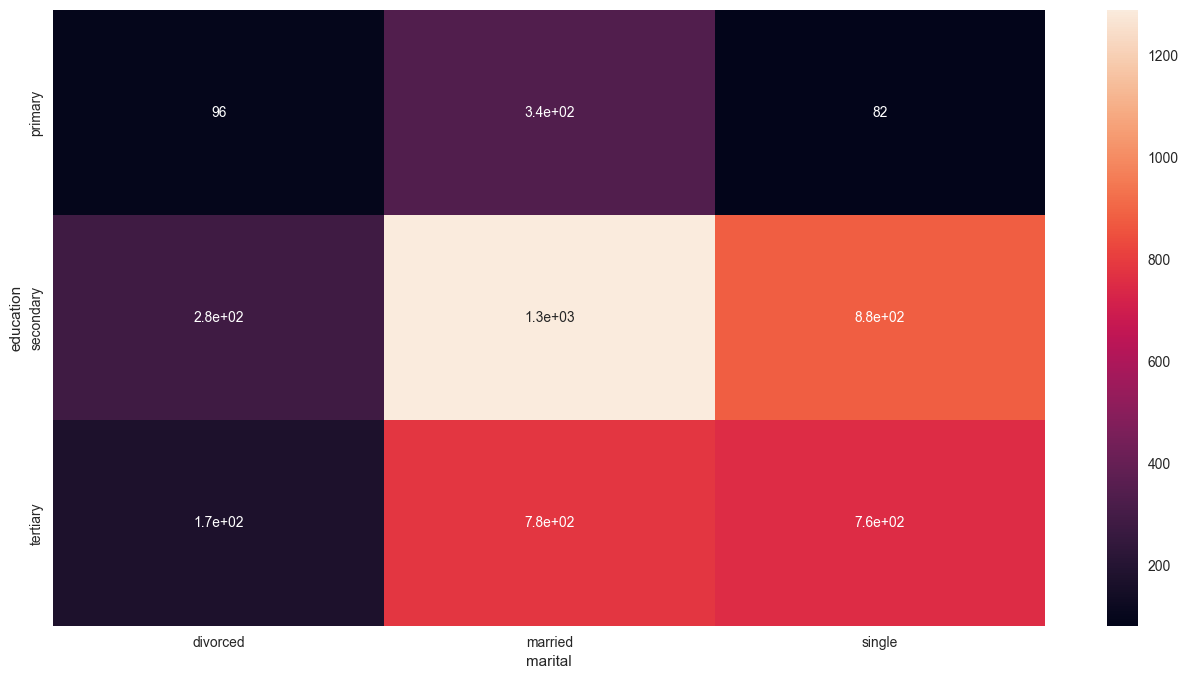

In [19]:
pivot_table = pd.pivot_table(
    data=df[df['deposit'] == 'yes'],
    values='deposit',
    index='education',
    columns='marital',
    aggfunc='count'
)

fig, ax = plt.subplots(1, 1, figsize = (16, 8))
heatmap = sns.heatmap(pivot_table, annot=True, ax=ax)

## Часть 3: преобразование данных

Закодируем категориальные переменные.

In [20]:
encoder = LabelEncoder()
df['education'] = encoder.fit_transform(df['education'])
df['age_groups'] = encoder.fit_transform(df['age_groups'])

Закодируем бинарные переменные, в том числе и целевой признак.

In [21]:
for feature in ['deposit', 'default', 'housing', 'loan']:
    df[feature] = df[feature].apply(lambda x: 1 if x == 'yes' else 0)

Теперь преобразуем номинальные переменные, которые могут принимать несколько различных значений.

In [22]:
df = pd.get_dummies(df)
df.shape

(10105, 46)

Изучим наши данные на мультиколлинеарность, для этого построим тепловую карту матрицы коллинеарности. Будем считать, что между признаками присутствует мультиколлинеарность, если значение коллинеарности выше 0.9. 

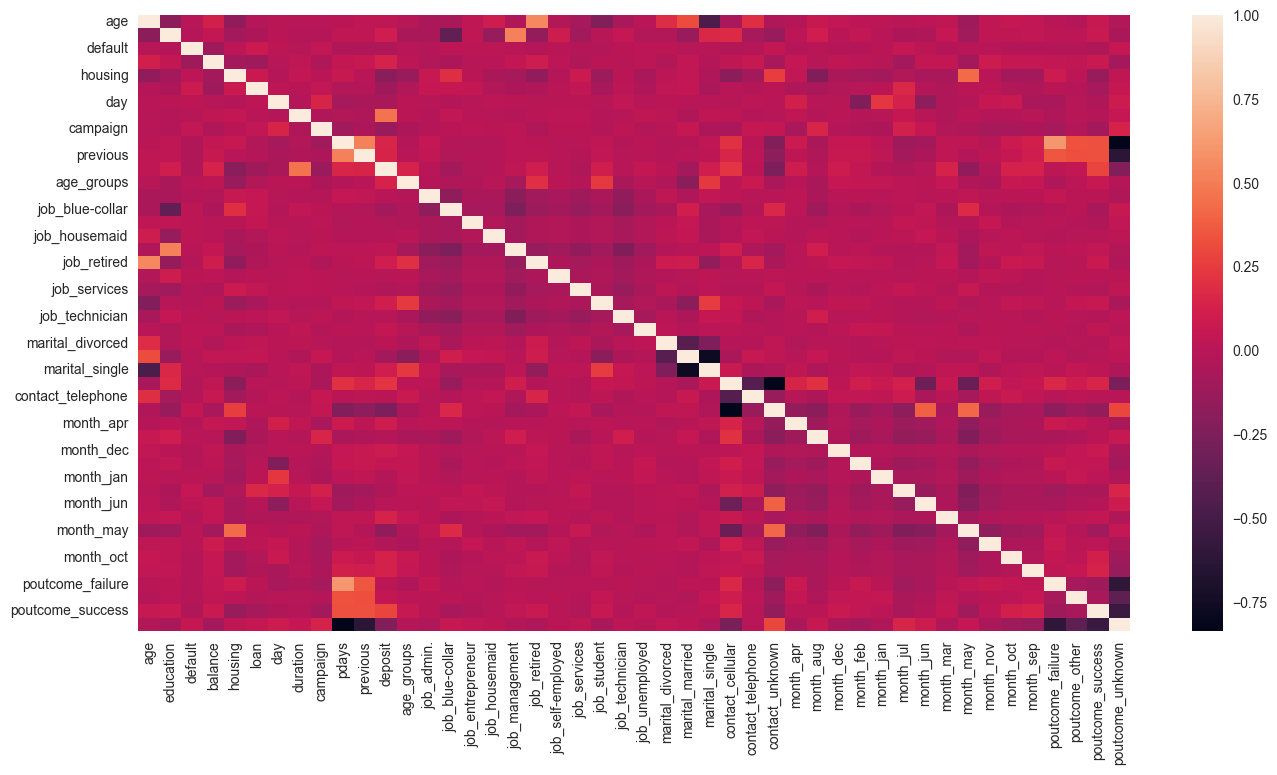

In [23]:
corr = df.corr()

fig, ax = plt.subplots(1, 1, figsize = (16, 8))
heatmap = sns.heatmap(corr, ax=ax)

Следующим шагом разобьем нашу выборку на обучающую и тестовую.

In [24]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

На данный момент в данных имеется довольно-таки большое количество признаков. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.

С помощью SelectKBest отберем 15 признаков, наилучшим образом подходящих для использования в задаче.

In [25]:
selector = SelectKBest(score_func=f_classif, k=15)
selector.feature_names_in_ = df.drop('deposit', axis=1).columns
selector.fit(X_train, y_train)

X_train = selector.transform(X_train)
X_test = selector.transform(X_test)

res_columns = selector.get_feature_names_out()
res_columns

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_groups', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

Следующим шагом нормализуем наши данные, используя min-max-scaler.

In [26]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

Давайте обучим нашу первую модель, это будет логистическая регрессия.

In [27]:
# обучите логистическую регрессию и рассчитайте метрики качества
lr_model = linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

y_pred_train = lr_model.predict(X_train_scaled)
y_pred_test = lr_model.predict(X_test_scaled)
print(f'Accuracy на тренировочной выборке: {metrics.accuracy_score(y_train, y_pred_train)}')
print(f'Логистическая регрессия метрики на тестовой выборке:\n {metrics.classification_report(y_test, y_pred_test)}')

Accuracy на тренировочной выборке: 0.823781388478582
Логистическая регрессия метрики на тестовой выборке:
               precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.74      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.81      3335
weighted avg       0.81      0.81      0.81      3335



Теперь построим алгоритм посложнее - решаюшее дерево c глубиной 6.

In [28]:
dt_model = tree.DecisionTreeClassifier(max_depth=6, criterion='entropy', random_state=42)
dt_model.fit(X_train_scaled, y_train)

y_pred_train = dt_model.predict(X_train_scaled)
y_pred_test = dt_model.predict(X_test_scaled)
print(f'Accuracy на тренировочной выборке: {metrics.accuracy_score(y_train, y_pred_train)}')
print(f'Решающее дерево метрики на тестовой выборке:\n {metrics.classification_report(y_test, y_pred_test)}')

Accuracy на тренировочной выборке: 0.8180206794682422
Решающее дерево метрики на тестовой выборке:
               precision    recall  f1-score   support

           0       0.85      0.77      0.81      1790
           1       0.76      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



Займемся подбором гиперпараметров для решающего дерева, сделаем это с помощью GridSearchCV.

In [29]:
# подберите оптимальные параметры с помощью
param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth':[3,5,7]
}
model_cv = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42, criterion='entropy'),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

model_cv.fit(X_train_scaled, y_train)

print(f'Лучшие параметры:{model_cv.best_params_}')

y_pred_train = model_cv.predict(X_train_scaled)
y_pred_test = model_cv.predict(X_test_scaled)
print(f'Accuracy на тренировочной выборке: {metrics.accuracy_score(y_train, y_pred_train)}')
print(f'Решающее дерево метрики на тестовой выборке:\n {metrics.classification_report(y_test, y_pred_test)}')

Лучшие параметры:{'max_depth': 7, 'min_samples_split': 10}
Accuracy на тренировочной выборке: 0.8353028064992615
Решающее дерево метрики на тестовой выборке:
               precision    recall  f1-score   support

           0       0.84      0.81      0.82      1790
           1       0.79      0.82      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

Давайте теперь построим еще более сложные модели, чтобы повысить качество нашей метрики, для начала обучим модель случайного леса.

In [30]:
rf_model = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42
)
rf_model.fit(X_train_scaled, y_train)

y_pred_train = rf_model.predict(X_train_scaled)
y_pred_test = rf_model.predict(X_test_scaled)
print(f'Accuracy на тренировочной выборке: {metrics.accuracy_score(y_train, y_pred_train)}')
print(f'Решающее дерево метрики на тестовой выборке:\n {metrics.classification_report(y_test, y_pred_test)}')

Accuracy на тренировочной выборке: 0.8573116691285081
Решающее дерево метрики на тестовой выборке:
               precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Теперь обучим модель градиентного бустинга.

In [31]:
gb_model = ensemble.GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
)

gb_model.fit(X_train_scaled, y_train)

y_pred_train = gb_model.predict(X_train_scaled)
y_pred_test = gb_model.predict(X_test_scaled)
print(f'Accuracy на тренировочной выборке: {metrics.accuracy_score(y_train, y_pred_train)}')
print(f'Решающее дерево метрики на тестовой выборке:\n {metrics.classification_report(y_test, y_pred_test)}')

Accuracy на тренировочной выборке: 0.8867060561299852
Решающее дерево метрики на тестовой выборке:
               precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Последняя модель, которую мы реализуем будет стэкинг.

In [32]:
gb_model_for_stack = ensemble.GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
)
estimators = [
    ('lr', linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000)),
    ('dt', tree.DecisionTreeClassifier(max_depth=7, min_samples_leaf=2, criterion='entropy', random_state=42)),
    ('gb', gb_model_for_stack)
]

stack_model = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000),
    n_jobs=-1
)
stack_model.fit(X_train_scaled, y_train)

y_pred_train = stack_model.predict(X_train_scaled)
y_pred_test = stack_model.predict(X_test_scaled)
print(f'Accuracy на тренировочной выборке: {metrics.accuracy_score(y_train, y_pred_train)}')
print(f'Решающее дерево метрики на тестовой выборке:\n {metrics.classification_report(y_test, y_pred_test)}')

Accuracy на тренировочной выборке: 0.869423929098966
Решающее дерево метрики на тестовой выборке:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



Из полученных моделей можно сделать вывод, что наилучшее значение метрики accuracy мы получили с помощью градиентного бустинга. Давайте посмотрим какие признаки эта модель считает наиболее важными.

In [33]:
importances = []
for el in zip(res_columns, gb_model.feature_importances_):
    importances.append(el)
importances = sorted(importances, key=lambda x: x[1], reverse=True)
pd.DataFrame(importances, columns=['feature', 'coef'])

,feature,coef
0,duration,0.507106
1,poutcome_success,0.114958
2,contact_unknown,0.072582
3,balance,0.057952
4,pdays,0.055083
5,housing,0.047725
6,age_groups,0.039902
7,month_mar,0.027819
8,month_oct,0.019880
9,month_may,0.015245


Попробуем воспользоваться другим способом подбора гиперпараметров с помощью Optuna.

In [34]:
import optuna

In [43]:
def optuna_rf(trial, cv=5):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
  # создаем модель
  model = ensemble.RandomForestClassifier(
                                 n_estimators=n_estimators,
                                 criterion='gini',
                                 max_depth=max_depth,
                                 min_samples_leaf=min_samples_leaf,
                                 random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="f1", n_jobs=-1).mean()
  
  return score

In [44]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=40);

[I 2024-03-24 18:39:46,717] A new study created in memory with name: RandomForestClassifier
[I 2024-03-24 18:39:48,070] Trial 0 finished with value: 0.8258882821548305 and parameters: {'n_estimators': 116, 'max_depth': 17, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8258882821548305.
[I 2024-03-24 18:39:49,934] Trial 1 finished with value: 0.8266840487145182 and parameters: {'n_estimators': 169, 'max_depth': 11, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8266840487145182.
[I 2024-03-24 18:39:52,000] Trial 2 finished with value: 0.8258509282604803 and parameters: {'n_estimators': 138, 'max_depth': 28, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8266840487145182.
[I 2024-03-24 18:39:55,021] Trial 3 finished with value: 0.8235858828022172 and parameters: {'n_estimators': 194, 'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8266840487145182.
[I 2024-03-24 18:39:56,634] Trial 4 finished with value: 0.8244366150933935 and parameters: {'n_

CPU times: total: 18.4 s
Wall time: 1min 39s


In [46]:
rf_model = ensemble.RandomForestClassifier(
    n_estimators=183,
    criterion='gini',
    max_depth=12,
    min_samples_leaf=3,
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)

y_pred_train = rf_model.predict(X_train_scaled)
y_pred_test = rf_model.predict(X_test_scaled)
print(f'Accuracy на тренировочной выборке: {metrics.accuracy_score(y_train, y_pred_train)}')
print(f'Решающее дерево метрики на тестовой выборке:\n {metrics.classification_report(y_test, y_pred_test)}')

Accuracy на тренировочной выборке: 0.8751846381093058
Решающее дерево метрики на тестовой выборке:
               precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

